In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error

In [2]:
params = {
    'epochs': 200,
    'test_size': 0.2,
    'random_state': 1337,
    'validation_split': 0.2
}

In [3]:
df = pd.read_csv("../data/qsc_out.random_scan_nfp2.csv")

In [4]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y0,y1,y2,y3,y4,y5,y6
0,-0.104856,0.197790,0.001260,-0.011792,0.000794,0.000120,-0.687180,-0.215177,0.948834,0.264545,0.404154,0.631039,0.898928,1.581192,0.334374
1,-0.110385,0.188144,0.001381,-0.011358,0.000855,0.000138,-0.658897,-0.233486,0.930837,0.298531,0.469811,0.639501,0.876879,1.568947,0.336379
2,-0.095042,0.132051,0.000675,-0.008909,0.000477,0.000348,-0.671871,-0.944641,1.526347,0.385624,0.334515,0.468280,0.804239,1.288313,0.331086
3,-0.115912,-0.207162,0.001411,0.012060,0.000871,-0.000108,-0.736734,0.012462,0.783335,0.278748,0.497138,0.645087,0.926717,1.717088,0.338459
4,-0.096390,-0.217079,0.000933,0.010517,0.000621,-0.000126,-0.764525,-0.048433,0.925351,0.272636,0.548743,0.631384,0.941509,1.549327,0.331432


<Axes: >

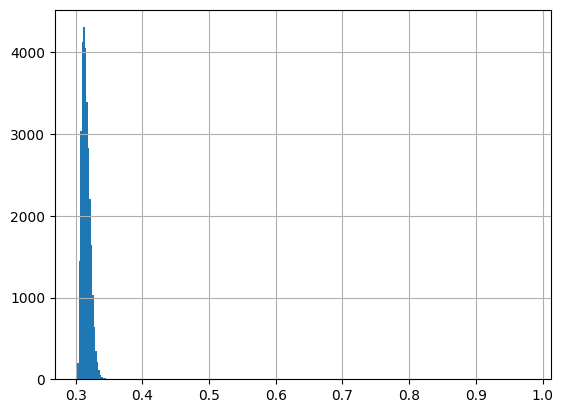

In [5]:
df['y6'].hist(bins=300)

In [6]:
df['y6'].max()

0.9784476541301952

In [7]:
df.shape

(29674, 15)

In [8]:
x_columns = [col for col in df.columns if col.startswith('x')]
y_columns = [col for col in df.columns if col.startswith('y')]

Y = df[y_columns].values
X = df[x_columns].values

In [9]:
def preprocess_data(X_train, X_test, Y_train, Y_test, params):
    scaler_x = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(Y_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)
    Y_train = scaler_y.transform(Y_train)
    Y_test = scaler_y.transform(Y_test)

    input_shape = X_train.shape[1]
    
    output_shape = Y_train.shape[1]
    return X_train, X_test, Y_train, Y_test, input_shape, output_shape, scaler_x, scaler_y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=params['test_size'], 
                                                    random_state=params['random_state'])

X_train, X_test, Y_train, Y_test, input_shape, output_shape, scaler_x, scaler_y = preprocess_data(X_train, X_test, Y_train, Y_test, params)

In [10]:
X_train.mean(axis=0), X_train.std(axis=0) 

(array([-1.86603895e-17, -2.39778990e-17, -4.12750044e-17, -8.97978632e-17,
         1.45237693e-17,  4.88584184e-17, -7.02959790e-15, -1.74744727e-15]),
 array([1., 1., 1., 1., 1., 1., 1., 1.]))

## Appears to be drift, perhaps the sample is not big enough

In [11]:
X_test.mean(axis=0), X_test.std(axis=0) 

(array([ 0.01621399, -0.00112999,  0.01755134,  0.01955565,  0.01673425,
         0.00871709, -0.01095845, -0.02030808]),
 array([0.99488322, 0.99650294, 0.78686316, 0.96749519, 0.93053514,
        0.90833692, 1.01170468, 1.00410648]))

In [12]:
Y_train.mean(axis=0), Y_train.std(axis=0) 

(array([-1.23324421e-14,  2.75938148e-14, -7.59591967e-15, -1.74703992e-14,
        -3.12392412e-14, -5.68256506e-14, -1.97065971e-13]),
 array([1., 1., 1., 1., 1., 1., 1.]))

In [13]:
Y_test.mean(axis=0), Y_test.std(axis=0)

(array([ 0.002863  ,  0.0093879 , -0.00576779, -0.01150026, -0.01160122,
        -0.01466698, -0.0055547 ]),
 array([1.00800321, 1.00616058, 1.0009353 , 0.99290648, 0.99481008,
        1.00920012, 0.71155792]))

## Dummy regressor

In [14]:
from sklearn.dummy import DummyRegressor

In [15]:
regr = MultiOutputRegressor(DummyRegressor(strategy="mean")).fit(X_train, Y_train)
regr.predict(X_train)

array([[-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13],
       [-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13],
       [-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13],
       ...,
       [-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13],
       [-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13],
       [-1.23299623e-14,  2.76159547e-14, -7.59899700e-15, ...,
        -3.12143139e-14, -5.68119908e-14, -1.97071672e-13]])

In [16]:
mean_absolute_error(Y_train, regr.predict(X_train))

0.7819301538758372

In [17]:
mean_absolute_error(Y_test, regr.predict(X_test))

0.7826444903716244

## Train a linear regression for debugging

In [18]:
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, Y_train)
regr.predict(X_train)

array([[-0.01118562, -0.25258042, -0.07693146, ...,  0.15934534,
         0.02889025, -0.02566576],
       [ 0.33075672,  0.74101837,  0.27335388, ..., -0.3718137 ,
        -0.14318812, -0.4488022 ],
       [-0.22386175, -0.38369246, -0.11028056, ...,  0.22433786,
         0.10529634,  0.09333019],
       ...,
       [ 0.01024576, -0.05781049, -0.02785113, ..., -0.06734454,
        -0.04966926,  0.16428362],
       [-0.09533647, -0.20393649, -0.04846468, ...,  0.42137434,
         0.14091655,  1.00339397],
       [-0.10952675, -0.16497835, -0.03597803, ...,  0.16906614,
         0.06585663,  0.100133  ]])

In [19]:
mean_absolute_error(Y_train, regr.predict(X_train))

0.7420778534372884

In [20]:
mean_absolute_error(Y_test, regr.predict(X_test))

0.7453412087802475

## Simplest neural network

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(input_shape, activation="relu", name="layer_in"),
        layers.Dense(128, activation="relu", name="layer2"),
        layers.Dense(64, activation="relu", name="layer3"),
        layers.Dense(output_shape, name="layer_out"),
    ]
)

model(X_train[0:1])

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.10294949, -0.28713128,  0.07401746, -0.14377841, -0.08267734,
         0.33238086,  0.27510813]], dtype=float32)>

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_in (Dense)            (1, 8)                    72        
                                                                 
 layer2 (Dense)              (1, 128)                  1152      
                                                                 
 layer3 (Dense)              (1, 64)                   8256      
                                                                 
 layer_out (Dense)           (1, 7)                    455       
                                                                 
Total params: 9935 (38.81 KB)
Trainable params: 9935 (38.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

In [25]:
print("Fit model on training data")
history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs=400,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, Y_test),
)

Fit model on training data
Epoch 1/400
371/371 [==============================] - 0s 719us/step - loss: 0.6620 - mean_absolute_error: 0.6620 - val_loss: 0.5994 - val_mean_absolute_error: 0.5994
Epoch 2/400
371/371 [==============================] - 0s 550us/step - loss: 0.5583 - mean_absolute_error: 0.5583 - val_loss: 0.5222 - val_mean_absolute_error: 0.5222
Epoch 3/400
371/371 [==============================] - 0s 593us/step - loss: 0.4880 - mean_absolute_error: 0.4880 - val_loss: 0.4619 - val_mean_absolute_error: 0.4619
Epoch 4/400
371/371 [==============================] - 0s 540us/step - loss: 0.4404 - mean_absolute_error: 0.4404 - val_loss: 0.4132 - val_mean_absolute_error: 0.4132
Epoch 5/400
371/371 [==============================] - 0s 603us/step - loss: 0.4111 - mean_absolute_error: 0.4111 - val_loss: 0.3835 - val_mean_absolute_error: 0.3835
Epoch 6/400
371/371 [==============================] - 0s 535us/step - loss: 0.3922 - mean_absolute_error: 0.3922 - val_loss: 0.4112 - val

Epoch 50/400
371/371 [==============================] - 0s 511us/step - loss: 0.2182 - mean_absolute_error: 0.2182 - val_loss: 0.2194 - val_mean_absolute_error: 0.2194
Epoch 51/400
371/371 [==============================] - 0s 512us/step - loss: 0.2163 - mean_absolute_error: 0.2163 - val_loss: 0.2099 - val_mean_absolute_error: 0.2099
Epoch 52/400
371/371 [==============================] - 0s 508us/step - loss: 0.2158 - mean_absolute_error: 0.2158 - val_loss: 0.2121 - val_mean_absolute_error: 0.2121
Epoch 53/400
371/371 [==============================] - 0s 564us/step - loss: 0.2142 - mean_absolute_error: 0.2142 - val_loss: 0.2257 - val_mean_absolute_error: 0.2257
Epoch 54/400
371/371 [==============================] - 0s 511us/step - loss: 0.2137 - mean_absolute_error: 0.2137 - val_loss: 0.2161 - val_mean_absolute_error: 0.2161
Epoch 55/400
371/371 [==============================] - 0s 507us/step - loss: 0.2129 - mean_absolute_error: 0.2129 - val_loss: 0.2064 - val_mean_absolute_error:

Epoch 99/400
371/371 [==============================] - 0s 511us/step - loss: 0.1853 - mean_absolute_error: 0.1853 - val_loss: 0.1912 - val_mean_absolute_error: 0.1912
Epoch 100/400
371/371 [==============================] - 0s 507us/step - loss: 0.1844 - mean_absolute_error: 0.1844 - val_loss: 0.1867 - val_mean_absolute_error: 0.1867
Epoch 101/400
371/371 [==============================] - 0s 504us/step - loss: 0.1836 - mean_absolute_error: 0.1836 - val_loss: 0.1818 - val_mean_absolute_error: 0.1818
Epoch 102/400
371/371 [==============================] - 0s 505us/step - loss: 0.1833 - mean_absolute_error: 0.1833 - val_loss: 0.1783 - val_mean_absolute_error: 0.1783
Epoch 103/400
371/371 [==============================] - 0s 507us/step - loss: 0.1828 - mean_absolute_error: 0.1828 - val_loss: 0.1751 - val_mean_absolute_error: 0.1751
Epoch 104/400
371/371 [==============================] - 0s 506us/step - loss: 0.1823 - mean_absolute_error: 0.1823 - val_loss: 0.1929 - val_mean_absolute_e

371/371 [==============================] - 0s 515us/step - loss: 0.1529 - mean_absolute_error: 0.1529 - val_loss: 0.1698 - val_mean_absolute_error: 0.1698
Epoch 148/400
371/371 [==============================] - 0s 511us/step - loss: 0.1524 - mean_absolute_error: 0.1524 - val_loss: 0.1508 - val_mean_absolute_error: 0.1508
Epoch 149/400
371/371 [==============================] - 0s 504us/step - loss: 0.1517 - mean_absolute_error: 0.1517 - val_loss: 0.1455 - val_mean_absolute_error: 0.1455
Epoch 150/400
371/371 [==============================] - 0s 516us/step - loss: 0.1507 - mean_absolute_error: 0.1507 - val_loss: 0.1546 - val_mean_absolute_error: 0.1546
Epoch 151/400
371/371 [==============================] - 0s 515us/step - loss: 0.1509 - mean_absolute_error: 0.1509 - val_loss: 0.1474 - val_mean_absolute_error: 0.1474
Epoch 152/400
371/371 [==============================] - 0s 513us/step - loss: 0.1503 - mean_absolute_error: 0.1503 - val_loss: 0.1523 - val_mean_absolute_error: 0.1523


371/371 [==============================] - 0s 535us/step - loss: 0.1361 - mean_absolute_error: 0.1361 - val_loss: 0.1341 - val_mean_absolute_error: 0.1341
Epoch 196/400
371/371 [==============================] - 0s 512us/step - loss: 0.1354 - mean_absolute_error: 0.1354 - val_loss: 0.1397 - val_mean_absolute_error: 0.1397
Epoch 197/400
371/371 [==============================] - 0s 509us/step - loss: 0.1352 - mean_absolute_error: 0.1352 - val_loss: 0.1390 - val_mean_absolute_error: 0.1390
Epoch 198/400
371/371 [==============================] - 0s 506us/step - loss: 0.1348 - mean_absolute_error: 0.1348 - val_loss: 0.1401 - val_mean_absolute_error: 0.1401
Epoch 199/400
371/371 [==============================] - 0s 505us/step - loss: 0.1349 - mean_absolute_error: 0.1349 - val_loss: 0.1317 - val_mean_absolute_error: 0.1317
Epoch 200/400
371/371 [==============================] - 0s 515us/step - loss: 0.1344 - mean_absolute_error: 0.1344 - val_loss: 0.1434 - val_mean_absolute_error: 0.1434


371/371 [==============================] - 0s 562us/step - loss: 0.1266 - mean_absolute_error: 0.1266 - val_loss: 0.1237 - val_mean_absolute_error: 0.1237
Epoch 244/400
371/371 [==============================] - 0s 512us/step - loss: 0.1263 - mean_absolute_error: 0.1263 - val_loss: 0.1188 - val_mean_absolute_error: 0.1188
Epoch 245/400
371/371 [==============================] - 0s 593us/step - loss: 0.1260 - mean_absolute_error: 0.1260 - val_loss: 0.1302 - val_mean_absolute_error: 0.1302
Epoch 246/400
371/371 [==============================] - 0s 535us/step - loss: 0.1257 - mean_absolute_error: 0.1257 - val_loss: 0.1340 - val_mean_absolute_error: 0.1340
Epoch 247/400
371/371 [==============================] - 0s 520us/step - loss: 0.1256 - mean_absolute_error: 0.1256 - val_loss: 0.1295 - val_mean_absolute_error: 0.1295
Epoch 248/400
371/371 [==============================] - 0s 512us/step - loss: 0.1256 - mean_absolute_error: 0.1256 - val_loss: 0.1229 - val_mean_absolute_error: 0.1229


371/371 [==============================] - 0s 523us/step - loss: 0.1205 - mean_absolute_error: 0.1205 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 292/400
371/371 [==============================] - 0s 511us/step - loss: 0.1200 - mean_absolute_error: 0.1200 - val_loss: 0.1303 - val_mean_absolute_error: 0.1303
Epoch 293/400
371/371 [==============================] - 0s 516us/step - loss: 0.1195 - mean_absolute_error: 0.1195 - val_loss: 0.1211 - val_mean_absolute_error: 0.1211
Epoch 294/400
371/371 [==============================] - 0s 531us/step - loss: 0.1199 - mean_absolute_error: 0.1199 - val_loss: 0.1177 - val_mean_absolute_error: 0.1177
Epoch 295/400
371/371 [==============================] - 0s 513us/step - loss: 0.1198 - mean_absolute_error: 0.1198 - val_loss: 0.1243 - val_mean_absolute_error: 0.1243
Epoch 296/400
371/371 [==============================] - 0s 511us/step - loss: 0.1193 - mean_absolute_error: 0.1193 - val_loss: 0.1170 - val_mean_absolute_error: 0.1170


371/371 [==============================] - 0s 570us/step - loss: 0.1156 - mean_absolute_error: 0.1156 - val_loss: 0.1223 - val_mean_absolute_error: 0.1223
Epoch 340/400
371/371 [==============================] - 0s 521us/step - loss: 0.1153 - mean_absolute_error: 0.1153 - val_loss: 0.1153 - val_mean_absolute_error: 0.1153
Epoch 341/400
371/371 [==============================] - 0s 515us/step - loss: 0.1150 - mean_absolute_error: 0.1150 - val_loss: 0.1180 - val_mean_absolute_error: 0.1180
Epoch 342/400
371/371 [==============================] - 0s 512us/step - loss: 0.1154 - mean_absolute_error: 0.1154 - val_loss: 0.1174 - val_mean_absolute_error: 0.1174
Epoch 343/400
371/371 [==============================] - 0s 518us/step - loss: 0.1155 - mean_absolute_error: 0.1155 - val_loss: 0.1118 - val_mean_absolute_error: 0.1118
Epoch 344/400
371/371 [==============================] - 0s 514us/step - loss: 0.1151 - mean_absolute_error: 0.1151 - val_loss: 0.1210 - val_mean_absolute_error: 0.1210


371/371 [==============================] - 0s 525us/step - loss: 0.1120 - mean_absolute_error: 0.1120 - val_loss: 0.1183 - val_mean_absolute_error: 0.1183
Epoch 388/400
371/371 [==============================] - 0s 514us/step - loss: 0.1118 - mean_absolute_error: 0.1118 - val_loss: 0.1097 - val_mean_absolute_error: 0.1097
Epoch 389/400
371/371 [==============================] - 0s 528us/step - loss: 0.1122 - mean_absolute_error: 0.1122 - val_loss: 0.1144 - val_mean_absolute_error: 0.1144
Epoch 390/400
371/371 [==============================] - 0s 520us/step - loss: 0.1113 - mean_absolute_error: 0.1113 - val_loss: 0.1100 - val_mean_absolute_error: 0.1100
Epoch 391/400
371/371 [==============================] - 0s 517us/step - loss: 0.1122 - mean_absolute_error: 0.1122 - val_loss: 0.1183 - val_mean_absolute_error: 0.1183
Epoch 392/400
371/371 [==============================] - 0s 545us/step - loss: 0.1115 - mean_absolute_error: 0.1115 - val_loss: 0.1165 - val_mean_absolute_error: 0.1165


In [26]:
mean_absolute_error(Y_train, model.predict(X_train))

742/742 [==============================] - 0s 315us/step


0.10905128717603396

In [27]:
mean_absolute_error(Y_test, model.predict(X_test))

186/186 [==============================] - 0s 311us/step


0.11408455206590504